In [1]:
import numpy as np
import pandas as pd
import os
import json

In [2]:
labels = np.load("../Data/preprocessed/labels.npy", allow_pickle=True)
embeddings = np.load("../Data/preprocessed/embeddings.npy", allow_pickle=True)
classes = np.load("../Data/preprocessed/classes.npy", allow_pickle=True)

In [3]:
labels.shape, embeddings.shape

((4572, 4), (4572, 1280))

In [4]:
embeddings.dtype, labels.dtype

(dtype('float32'), dtype('int64'))

In [5]:
# Separate "all 0" samples
all_zero_indices = np.where(np.sum(labels, axis=1) == 0)[0]
embeddings_all_zero = embeddings[all_zero_indices]
labels_all_zero = labels[all_zero_indices]

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
embeddings_resampled, labels_resampled = smote.fit_resample(embeddings, labels)

embeddings_resampled_final = np.concatenate([embeddings_resampled, embeddings_all_zero], axis=0)
labels_resampled_final = np.concatenate([labels_resampled, labels_all_zero], axis=0)

In [6]:
pd.DataFrame(labels).value_counts()

0  1  2  3
0  0  0  0    2439
      1  0     910
1  0  0  0     500
0  0  0  1     420
   1  0  0     303
Name: count, dtype: int64

In [7]:
pd.DataFrame(labels_resampled).value_counts()

0  1  2  3
0  0  0  1    2939
      1  0    2939
   1  0  0    2939
1  0  0  0    2939
Name: count, dtype: int64

In [8]:
pd.DataFrame(labels_resampled_final).value_counts()

0  1  2  3
0  0  0  1    2939
      1  0    2939
   1  0  0    2939
1  0  0  0    2939
0  0  0  0    2439
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings_resampled, labels_resampled, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import accuracy_score, f1_score, classification_report

# --- Create the multi-label classification model ---
input_layer = Input(shape=(X_train.shape[1],))  # Input shape based on embeddings
hidden_layer1 = Dense(512, activation='relu')(input_layer)
dropout_layer = Dropout(0.5)(hidden_layer1)  # Add dropout for regularization
hidden_layer2 = Dense(256, activation='relu')(dropout_layer)
dropout_layer2 = Dropout(0.5)(hidden_layer2)  # Add dropout for regularization
hidden_layer3 = Dense(128, activation='relu')(dropout_layer2)
dropout_layer3 = Dropout(0.5)(hidden_layer3)  # Add dropout for regularization
hidden_layer4 = Dense(64, activation='relu')(dropout_layer3)
output_layer = Dense(y_train.shape[1], activation='softmax')(hidden_layer4)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 828,612 (3.16 MB)

 Trainable params: 828,612 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='model.keras', save_best_only=True)
callbacks=[early_stopping, learning_rate_reduction]

In [13]:
# Train the model
hist = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, callbacks=callbacks)
# model.save('model.keras')
# model.save('meme_sarcasm_detection_model.h5')

# Evaluate the model
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)  # Threshold predictions

accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='micro')  # Use appropriate averaging
classification_report_ = classification_report(y_test, predicted_labels, zero_division=0, target_names=classes)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Classification Report\n: {classification_report_}")

Epoch 1/200
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2881 - loss: 3.0721 - val_accuracy: 0.4067 - val_loss: 1.2644 - learning_rate: 1.0000e-04
Epoch 2/200
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3348 - loss: 1.5672 - val_accuracy: 0.4365 - val_loss: 1.2431 - learning_rate: 1.0000e-04
Epoch 3/200
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3559 - loss: 1.3942 - val_accuracy: 0.4721 - val_loss: 1.2046 - learning_rate: 1.0000e-04
Epoch 4/200
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4049 - loss: 1.2991 - val_accuracy: 0.5035 - val_loss: 1.1649 - learning_rate: 1.0000e-04
Epoch 5/200
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4326 - loss: 1.2444 - val_accuracy: 0.5545 - val_loss: 1.1213 - learning_rate: 1.0000e-04
Epoch 6/200
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4569 - loss: 1.1801 - val_accuracy: 0.5720 - val_loss: 1.0753 - learning_rate: 1.0000e-04
Epoch 7/200
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc

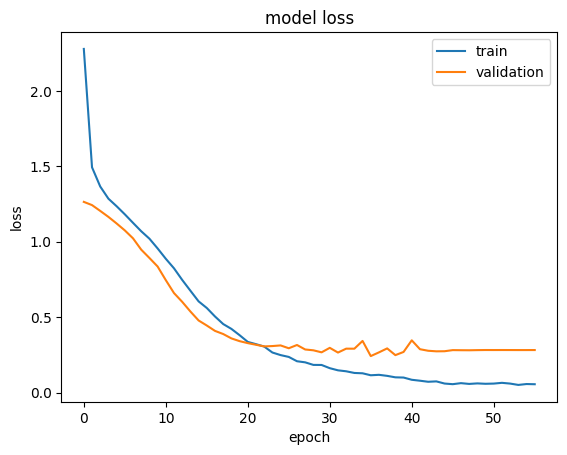

In [14]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

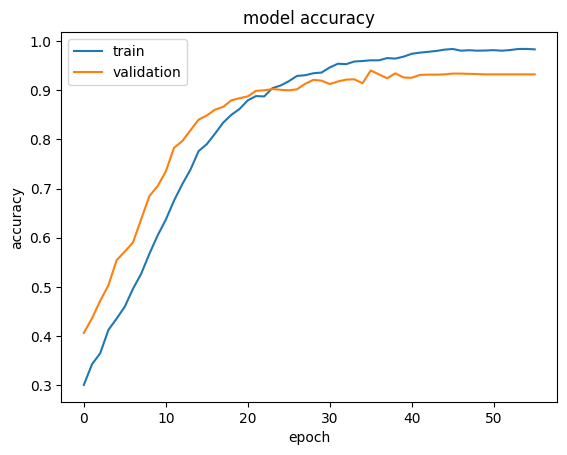

In [15]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
predictions

array([[5.3645700e-04, 9.9946332e-01, 2.5845056e-08, 1.2792553e-07],
       [2.5228407e-02, 1.0536655e-08, 9.7477156e-01, 1.5817980e-10],
       [7.9726015e-04, 9.9919713e-01, 7.0626390e-07, 4.8978636e-06],
       ...,
       [1.1895048e-05, 9.3886783e-09, 1.1814495e-11, 9.9998808e-01],
       [4.1868479e-04, 9.9957716e-01, 2.2005370e-06, 1.9990425e-06],
       [1.5273439e-02, 3.3088727e-07, 9.8472619e-01, 3.0537346e-09]],
      dtype=float32)

In [17]:
predicted_labels

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [18]:
y_test

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [19]:
y_train.argmax(axis=1)

array([3, 0, 1, ..., 1, 0, 2])

In [25]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter = 1000)
lr_model.fit(X_train, y_train.argmax(axis=1))

lr_model.score(X_train, y_train.argmax(axis=1)), lr_model.score(X_test, y_test.argmax(axis=1))

predicted_labels = lr_model.predict(X_test)
accuracy = accuracy_score(y_test.argmax(axis=1), predicted_labels)
classification_report_ = classification_report(y_test.argmax(axis=1), predicted_labels, zero_division=0, target_names=classes)

print(f"Accuracy: {accuracy}")
print(f"Classification Report\n: {classification_report_}")

Accuracy: 0.8664965986394558
Classification Report
:                precision    recall  f1-score   support

     misogyny       0.82      0.66      0.73       603
offensiveness       0.89      0.99      0.93       564
      sarcasm       0.87      0.89      0.88       569
  harmfulness       0.88      0.94      0.91       616

     accuracy                           0.87      2352
    macro avg       0.86      0.87      0.86      2352
 weighted avg       0.86      0.87      0.86      2352



/Users/gvssriram/Desktop/projects-internship/sarcasm-detector/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train, y_train.argmax(axis=1))

svc_model.score(X_train, y_train.argmax(axis=1)), svc_model.score(X_test, y_test.argmax(axis=1))

predicted_labels = svc_model.predict(X_test)
accuracy = accuracy_score(y_test.argmax(axis=1), predicted_labels)
classification_report_ = classification_report(y_test.argmax(axis=1), predicted_labels, zero_division=0, target_names=classes)

print(f"Accuracy: {accuracy}")
print(f"Classification Report\n: {classification_report_}")

Accuracy: 0.8405612244897959
Classification Report
:                precision    recall  f1-score   support

     misogyny       0.82      0.65      0.73       603
offensiveness       0.86      0.96      0.91       564
      sarcasm       0.80      0.81      0.80       569
  harmfulness       0.87      0.95      0.90       616

     accuracy                           0.84      2352
    macro avg       0.84      0.84      0.84      2352
 weighted avg       0.84      0.84      0.84      2352



In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train.argmax(axis=1))

rf_model.score(X_train, y_train.argmax(axis=1)), rf_model.score(X_test, y_test.argmax(axis=1))

predicted_labels = rf_model.predict(X_test)
accuracy = accuracy_score(y_test.argmax(axis=1), predicted_labels)
classification_report_ = classification_report(y_test.argmax(axis=1), predicted_labels, zero_division=0, target_names=classes)

print(f"Accuracy: {accuracy}")
print(f"Classification Report\n: {classification_report_}")

Accuracy: 0.9175170068027211
Classification Report
:                precision    recall  f1-score   support

     misogyny       0.91      0.77      0.83       603
offensiveness       0.91      0.99      0.95       564
      sarcasm       0.91      0.94      0.92       569
  harmfulness       0.93      0.98      0.95       616

     accuracy                           0.92      2352
    macro avg       0.92      0.92      0.92      2352
 weighted avg       0.92      0.92      0.92      2352



In [34]:
classification_report(y_test.argmax(axis=1), predicted_labels, zero_division=np.nan, target_names=classes)

'               precision    recall  f1-score   support\n\n     misogyny       0.93      0.85      0.89       603\noffensiveness       0.95      0.99      0.97       564\n      sarcasm       0.93      0.95      0.94       569\n  harmfulness       0.96      0.98      0.97       616\n\n     accuracy                           0.94      2352\n    macro avg       0.94      0.94      0.94      2352\n weighted avg       0.94      0.94      0.94      2352\n'

In [35]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train.argmax(axis=1))
xgb_model.score(X_train, y_train.argmax(axis=1)), xgb_model.score(X_test, y_test.argmax(axis=1))

predicted_labels = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test.argmax(axis=1), predicted_labels)
classification_report_ = classification_report(y_test.argmax(axis=1), predicted_labels, target_names=classes)

print(f"Accuracy: {accuracy}")
print(f"Classification Report\n: {classification_report_}")

Accuracy: 0.9056122448979592
Classification Report
:                precision    recall  f1-score   support

     misogyny       0.91      0.71      0.80       603
offensiveness       0.93      1.00      0.96       564
      sarcasm       0.88      0.92      0.90       569
  harmfulness       0.90      0.99      0.95       616

     accuracy                           0.91      2352
    macro avg       0.91      0.91      0.90      2352
 weighted avg       0.91      0.91      0.90      2352

